# Spotify x Reverberation Radio - The essence of Cool
Author: Ulysse Zampogna

The project consists in revealing the secrets of the best radio on earth: Reverberation. The radio is a collective of artists based in Austin texas, regularly featuring apperarences from all over the world. The radio releases one show every week. The music selection is excquisit and covers a broad and eclectic range of music history. 

This kernel uses a Spotify developer desktop to collect Reverberation tracklist. Future updates will use clustering techniques to reveal the main thema of the radio selection and classification algorithm to predict if a given title could enter the exquisit Reverberation playlist.

#### Useful Resources
- https://spotipy.readthedocs.io/en/2.19.0/

---
## Data Collection

#### API call setup

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set(style="ticks", context="poster")
plt.style.use("seaborn-poster")
%autosave 30

Autosaving every 30 seconds


In [2]:
client_id = #ENTER CLIENT_ID
client_secret = #ENTER CLIENT_SECRET_KEY

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#### Playlists extraction

First, we will extract a dozen playlists among which Reveberbation. The other ones will serve as benchmark during EDA and negative samples for the classification algorithm.

In [3]:
#get all tracks for a given playlist
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [4]:
#hand picked list of public playlist on Spotify
playlists = [['''Today's Top Hits''','spotify','37i9dQZF1DXcBWIGoYBM5M'],
 ['Your Favorite CoffeeHouse','spotify','37i9dQZF1DX6ziVCJnEm59'],
 ['RapCaviar','spotify','37i9dQZF1DX0XUsuxWHRQd'],
 ['Viva Latino','spotify','37i9dQZF1DX10zKzsJ2jva'],
 ['Hot Country','spotify','37i9dQZF1DX1lVhptIYRda'],
 ['New Music Friday','spotify','37i9dQZF1DX4JAvHpjipBk'],
 ['Peaceful Piano','spotify','37i9dQZF1DXcBWIGoYBM5M'],
 ['Are & Be','spotify','37i9dQZF1DX4SBhb3fqCJd'],
 ['Mint','spotify','37i9dQZF1DX4dyzvuaRJ0n'],
 ['Just Hits','spotify','37i9dQZF1DXcRXFNfZr7Tp'],
 ['Soft Pop Hits','spotify','37i9dQZF1DWTwnEm1IYyoj'],
 ['All Out 2000s','spotify','37i9dQZF1DX4o1oenSJRJd'],
 ['Reverberation','h0572wwbcwym536rga31czi84','4puKKbk5xNIpmtYUI2OYzt']]

In [5]:
#playlist extraction
pl_info = []
for pl in playlists:
    pl_name=pl[0]
    pl_track_list = get_playlist_tracks(pl[1],pl[2])
    pl_info.append([pl_name,pl_track_list])
    time.sleep(5)
    print('Playlist {} extracted'.format(pl_name))

Playlist Today's Top Hits extracted
Playlist Your Favorite CoffeeHouse extracted
Playlist RapCaviar extracted
Playlist Viva Latino extracted
Playlist Hot Country extracted
Playlist New Music Friday extracted
Playlist Peaceful Piano extracted
Playlist Are & Be extracted
Playlist Mint extracted
Playlist Just Hits extracted
Playlist Soft Pop Hits extracted
Playlist All Out 2000s extracted
Playlist Reverberation extracted


In [6]:
#Inspect first element
#pl_info[0][1][0]

#### Track_id extraction

Further processing is needed to extract the track_id out of each playlist item

In [7]:
#Instantiate function to extract track ids
def getTrackID(ids):
    id = []
    playlist = ids
    for item in playlist:
        id.append(item['track']['id'])
    return id

In [8]:
#Instantiate variables
pl_ids = []
tot_pl = 0
tot_ids = 0
positive_class = 0

#extract each track_id for each playlist
for pl in pl_info:
    ids = getTrackID(pl[1])
    pl_ids.append([pl[0],ids])
    tot_pl += 1
    tot_ids += len(ids)
    if pl[0]=='Reverberation':
        positive_class = len(ids)
    print('{} - # of collected ids: {}\n'.format(pl[0],len(ids)))
    time.sleep(5)
print('Total playlists collected: {}'.format(tot_pl))
print('Total ids collected: {}'.format(tot_ids))
print('Total positive class (Reverberation): {}, or {:.2%}'.format(positive_class,positive_class/tot_ids))
print('Total negative class (Other Playlist): {}'.format(tot_ids-positive_class))

Today's Top Hits - # of collected ids: 50

Your Favorite CoffeeHouse - # of collected ids: 125

RapCaviar - # of collected ids: 50

Viva Latino - # of collected ids: 50

Hot Country - # of collected ids: 51

New Music Friday - # of collected ids: 77

Peaceful Piano - # of collected ids: 50

Are & Be - # of collected ids: 50

Mint - # of collected ids: 100

Just Hits - # of collected ids: 80

Soft Pop Hits - # of collected ids: 100

All Out 2000s - # of collected ids: 150

Reverberation - # of collected ids: 1602

Total playlists collected: 13
Total ids collected: 2535
Total positive class (Reverberation): 1602, or 63.20%
Total negative class (Other Playlist): 933


#### Track features extraction

Now that we have a clean list of track_id, we can use sp.track & sp.audio_features from spotipy to collect detailed information on each track.

In [61]:
test_a

{'external_urls': {'spotify': 'https://open.spotify.com/artist/5ENvVuYziSYbmRtY23bCJt'},
 'followers': {'href': None, 'total': 659},
 'genres': ['disco'],
 'href': 'https://api.spotify.com/v1/artists/5ENvVuYziSYbmRtY23bCJt',
 'id': '5ENvVuYziSYbmRtY23bCJt',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab67616d0000b2735620545ac159028c581b4c3c',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67616d00001e025620545ac159028c581b4c3c',
   'width': 300},
  {'height': 64,
   'url': 'https://i.scdn.co/image/ab67616d000048515620545ac159028c581b4c3c',
   'width': 64}],
 'name': 'Usje Sukatma',
 'popularity': 21,
 'type': 'artist',
 'uri': 'spotify:artist:5ENvVuYziSYbmRtY23bCJt'}

In [64]:
#Instantiate function to extract track features
#Resource: https://developer.spotify.com/documentation/web-api/reference/#/
def getTrackFeatures(id,playlist):
    meta = sp.track(id)
    features = sp.audio_features(id)
    artist_id = meta['album']['artists'][0]['id']
    artist_features = sp.artist(artist_id)
    
    #metadata
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    genres = artist_features['genres']
    release_date = meta['album']['release_date']
    duration_ms = meta['duration_ms']
    popularity = meta['popularity']
    
    #feature from the data
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    valence = features[0]['valence']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    mode = features[0]['mode']
    type = features[0]['type']
    
    track = [playlist,id,name,album,artist,genres,release_date,popularity,acousticness,danceability,energy,valence,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,duration_ms,mode,type]
    return track

In [66]:
#extract track features
tracks = []
for pl_i,pl in enumerate(pl_ids):
    playlist = pl[0]
    ids = pl[1]
    for i in range(len(ids)):
        track = getTrackFeatures(ids[i],playlist)
        tracks.append(track)
        time.sleep(.5)
    print('Playlist {} - {}: Features extraction completed'.format(pl_i,playlist))

Playlist 0 - Today's Top Hits: Features extraction completed
Playlist 1 - Your Favorite CoffeeHouse: Features extraction completed
Playlist 2 - RapCaviar: Features extraction completed
Playlist 3 - Viva Latino: Features extraction completed
Playlist 4 - Hot Country: Features extraction completed
Playlist 5 - New Music Friday: Features extraction completed
Playlist 6 - Peaceful Piano: Features extraction completed
Playlist 7 - Are & Be: Features extraction completed
Playlist 8 - Mint: Features extraction completed
Playlist 9 - Just Hits: Features extraction completed
Playlist 10 - Soft Pop Hits: Features extraction completed
Playlist 11 - All Out 2000s: Features extraction completed
Playlist 12 - Reverberation: Features extraction completed


In [67]:
#Export data in csv file
track_columns=['playlist','id','name','album','artist','genres','release_date','popularity','acousticness','danceability','energy','valence','instrumentalness','liveness','loudness','speechiness','tempo','time_signature','duration_ms','mode','type']
df = pd.DataFrame(tracks, columns=track_columns)
df.to_csv('./data/rvb_data.csv', sep=',',index=False)

In [68]:
#Quick check df
print('Total duration in hours: {:.0f}\n'.format(df.duration_ms.sum()/(1000*60*60)))
print(df.playlist.unique().tolist())
df.head()

Total duration in hours: 156

["Today's Top Hits", 'Your Favorite CoffeeHouse', 'RapCaviar', 'Viva Latino', 'Hot Country', 'New Music Friday', 'Peaceful Piano', 'Are & Be', 'Mint', 'Just Hits', 'Soft Pop Hits', 'All Out 2000s', 'Reverberation']


playlist                      id                       name  \
0  Today's Top Hits  6bQfNiqyCX7UaQSvVVGo4I                    Shivers   
1  Today's Top Hits  4fouWK6XVHhzl78KzQ1UjL                    abcdefu   
2  Today's Top Hits  5HCyWlXZPP0y6Gqq8TgA20  STAY (with Justin Bieber)   
3  Today's Top Hits  6zSpb8dQRaw0M1dK8PBwQz    Cold Heart - PNAU Remix   
4  Today's Top Hits  0gplL1WMoJ6iYaPgMCL0gX                 Easy On Me   

                       album         artist  \
0                    Shivers     Ed Sheeran   
1                    abcdefu          GAYLE   
2  STAY (with Justin Bieber)  The Kid LAROI   
3    Cold Heart (PNAU Remix)     Elton John   
4                 Easy On Me          Adele   

                                  genres release_date  popularity  \
0                          [pop, uk pop]   2021-09-10          52   
1                                     []   2021-08-13          98   
2                   [australian hip hop]   2021-07-09          97   
3   [glam rock, mellow gold, piano rock]   2021-08-13          96   
4  [british soul, pop, pop soul, uk pop]   2021-10-14          98   

   acousticness  danceability  ...  valence  instrumentalness  liveness  \
0        0.2810         0.788  ...    0.822          0.000000    0.0424   
1        0.2990         0.695  ...    0.415          0.000000    0.3670   
2        0.0383         0.591  ...    0.478          0.000000    0.1030   
3        0.0340         0.796  ...    0.942          0.000042    0.0952   
4        0.5780         0.604  ...    0.130          0.000000    0.1330   

   loudness  speechiness    tempo  time_signature  duration_ms  mode  \
0    -2.724       0.0856  141.020               4       207853     1   
1    -5.692       0.0493  121.932               4       168601     1   
2    -5.484       0.0483  169.928               4       141805     1   
3    -6.312       0.0317  116.032               4       202735     1   
4    -7.519       0.0282  141.981               4       224694     1   

             type  
0  audio_features  
1  audio_features  
2  audio_features  
3  audio_features  
4  audio_features  

[5 rows x 21 columns]

---
## Exploratory Data Analysis

### Basic exploration

In [69]:
df = pd.read_csv('./data/rvb_data.csv', sep=',')

In [70]:
df.head()

playlist                      id                       name  \
0  Today's Top Hits  6bQfNiqyCX7UaQSvVVGo4I                    Shivers   
1  Today's Top Hits  4fouWK6XVHhzl78KzQ1UjL                    abcdefu   
2  Today's Top Hits  5HCyWlXZPP0y6Gqq8TgA20  STAY (with Justin Bieber)   
3  Today's Top Hits  6zSpb8dQRaw0M1dK8PBwQz    Cold Heart - PNAU Remix   
4  Today's Top Hits  0gplL1WMoJ6iYaPgMCL0gX                 Easy On Me   

                       album         artist  \
0                    Shivers     Ed Sheeran   
1                    abcdefu          GAYLE   
2  STAY (with Justin Bieber)  The Kid LAROI   
3    Cold Heart (PNAU Remix)     Elton John   
4                 Easy On Me          Adele   

                                          genres release_date  popularity  \
0                              ['pop', 'uk pop']   2021-09-10          52   
1                                             []   2021-08-13          98   
2                         ['australian hip hop']   2021-07-09          97   
3     ['glam rock', 'mellow gold', 'piano rock']   2021-08-13          96   
4  ['british soul', 'pop', 'pop soul', 'uk pop']   2021-10-14          98   

   acousticness  danceability  ...  valence  instrumentalness  liveness  \
0        0.2810         0.788  ...    0.822          0.000000    0.0424   
1        0.2990         0.695  ...    0.415          0.000000    0.3670   
2        0.0383         0.591  ...    0.478          0.000000    0.1030   
3        0.0340         0.796  ...    0.942          0.000042    0.0952   
4        0.5780         0.604  ...    0.130          0.000000    0.1330   

   loudness  speechiness    tempo  time_signature  duration_ms  mode  \
0    -2.724       0.0856  141.020               4       207853     1   
1    -5.692       0.0493  121.932               4       168601     1   
2    -5.484       0.0483  169.928               4       141805     1   
3    -6.312       0.0317  116.032               4       202735     1   
4    -7.519       0.0282  141.981               4       224694     1   

             type  
0  audio_features  
1  audio_features  
2  audio_features  
3  audio_features  
4  audio_features  

[5 rows x 21 columns]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist          2535 non-null   object 
 1   id                2535 non-null   object 
 2   name              2535 non-null   object 
 3   album             2535 non-null   object 
 4   artist            2535 non-null   object 
 5   genres            2535 non-null   object 
 6   release_date      2535 non-null   object 
 7   popularity        2535 non-null   int64  
 8   acousticness      2535 non-null   float64
 9   danceability      2535 non-null   float64
 10  energy            2535 non-null   float64
 11  valence           2535 non-null   float64
 12  instrumentalness  2535 non-null   float64
 13  liveness          2535 non-null   float64
 14  loudness          2535 non-null   float64
 15  speechiness       2535 non-null   float64
 16  tempo             2535 non-null   float64


In [72]:
df.describe()

popularity  acousticness  danceability       energy      valence  \
count  2535.000000   2535.000000   2535.000000  2535.000000  2535.000000   
mean     35.265878      0.356837      0.591771     0.569446     0.562099   
std      30.318116      0.317258      0.154975     0.208069     0.243565   
min       0.000000      0.000009      0.086000     0.006810     0.000010   
25%       6.000000      0.057450      0.487000     0.421500     0.375000   
50%      31.000000      0.258000      0.601000     0.580000     0.569000   
75%      62.000000      0.629000      0.704000     0.733000     0.765000   
max      98.000000      0.995000      0.975000     0.994000     0.986000   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       2535.000000  2535.000000  2535.000000  2535.000000  2535.000000   
mean           0.165925     0.171659    -9.455523     0.062887   117.749526   
std            0.296892     0.138087     4.216179     0.062409    27.289949   
min            0.000000     0.023400   -33.522000     0.022700    46.591000   
25%            0.000001     0.093600   -11.854500     0.032400    96.696000   
50%            0.000918     0.117000    -8.739000     0.040400   116.765000   
75%            0.169500     0.196000    -6.334500     0.060650   134.019000   
max            0.977000     0.977000    -0.210000     0.539000   206.122000   

       time_signature   duration_ms         mode  
count     2535.000000  2.535000e+03  2535.000000  
mean         3.936489  2.217846e+05     0.667456  
std          0.336409  7.962538e+04     0.471218  
min          1.000000  3.999600e+04     0.000000  
25%          4.000000  1.726945e+05     0.000000  
50%          4.000000  2.046530e+05     1.000000  
75%          4.000000  2.494305e+05     1.000000  
max          5.000000  1.000688e+06     1.000000

In [76]:
categorical = df.select_dtypes(include=['object']).columns.tolist()

print('Number of Categorical variables: {}'.format(len(categorical)))
categorical

Number of Categorical variables: 8


['playlist', 'id', 'name', 'album', 'artist', 'genres', 'release_date', 'type']

In [74]:
continuous = df.select_dtypes(exclude=['object']).columns.tolist()

print('Number of Continuous variables: {}'.format(len(continuous)))
continuous

Number of Continuous variables: 13


['popularity',
 'acousticness',
 'danceability',
 'energy',
 'valence',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'duration_ms',
 'mode']

---
### Pairplot for continuous variables
Resources: https://seaborn.pydata.org/generated/seaborn.pairplot.html

Pairplot helps discovering the relationships in continuous variables by creating a scatter plot for each pair as well as plotting the distribution for each variable.

By default, this function will create a grid of Axes such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column.

In [77]:
#Continuous variables + playlist
cols= ['playlist',
 'popularity',
 'acousticness',
 'danceability',
 'energy',
 'valence',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'duration_ms']

#### Initiating color mapping to ensure consistency across all further visualizations

In [78]:
#https://matplotlib.org/stable/gallery/color/named_colors.html
pl_mapping = {
    "Today's Top Hits":'tab:blue',
 'Your Favorite CoffeeHouse':'tab:orange',
 'RapCaviar':'tab:green',
 'Viva Latino':'gold',
 'Hot Country':'tab:purple',
 'New Music Friday':'tab:brown',
 'Peaceful Piano':'tab:pink',
 'Are & Be':'tab:gray',
 'Mint':'tab:olive',
 'Just Hits':'tab:cyan',
 'Soft Pop Hits':'lime',
 'All Out 2000s':'royalblue',
 'Reverberation':'crimson'
}

#### Pairplot for all playlists

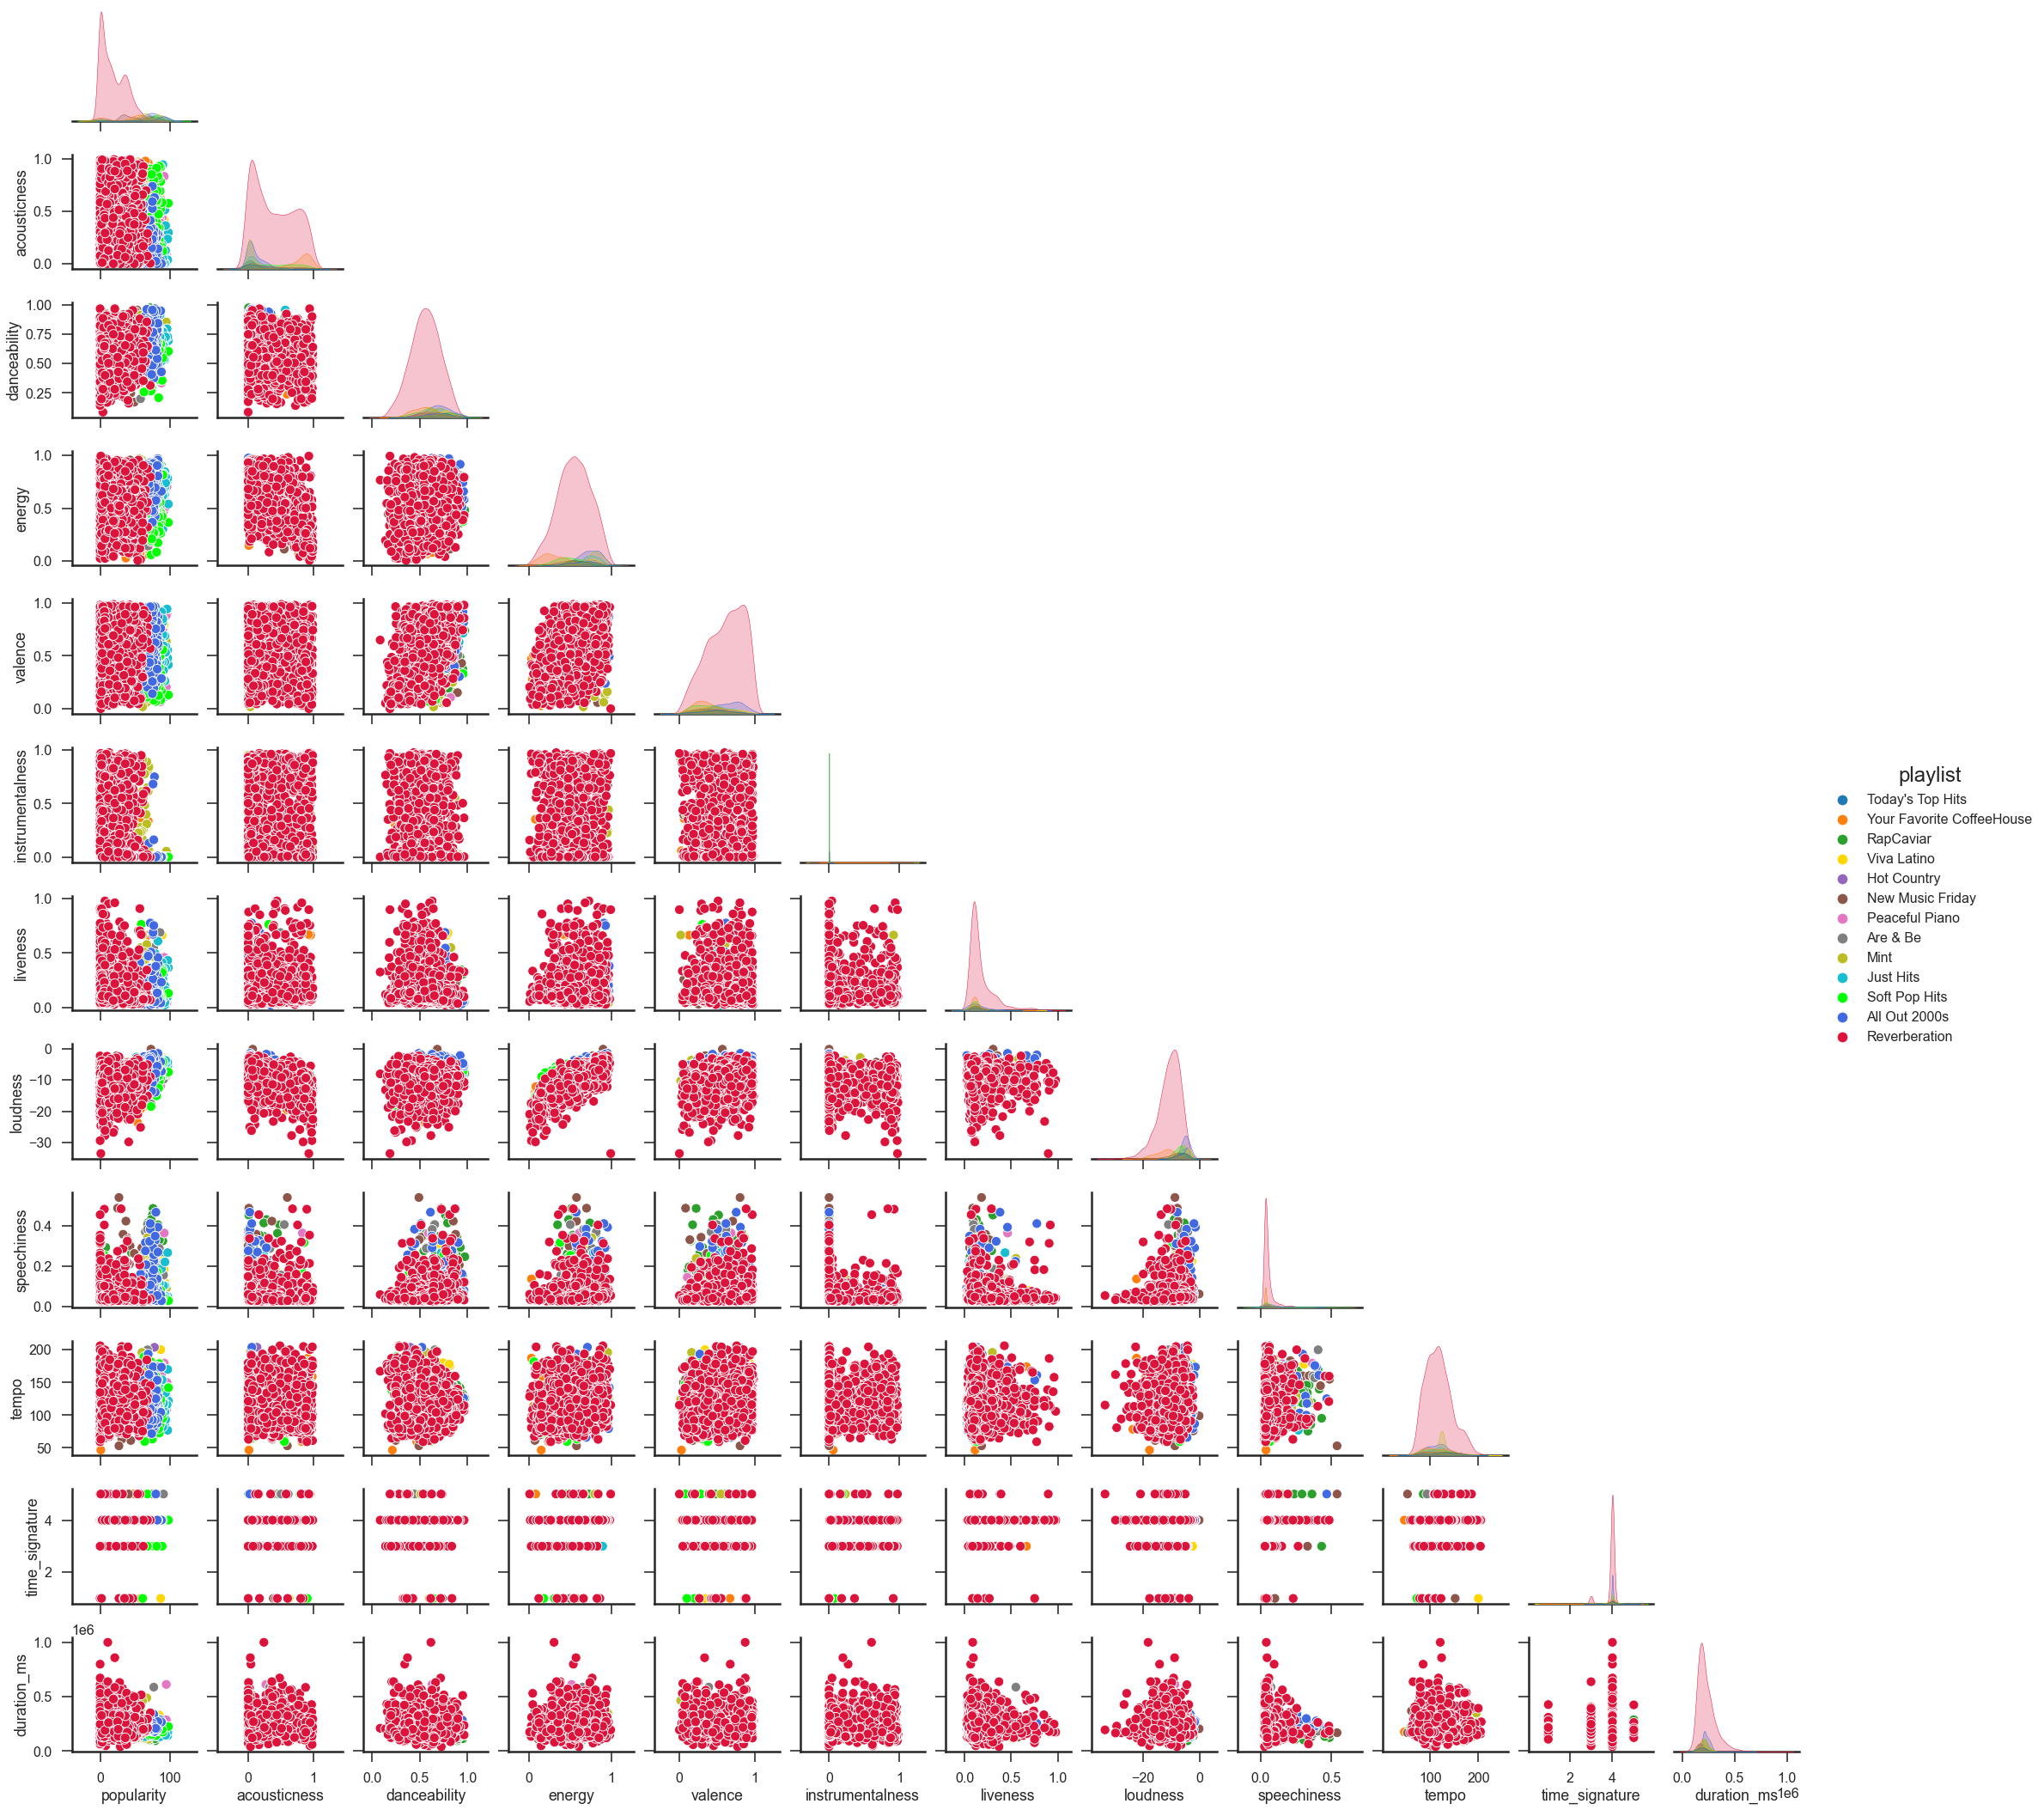

In [79]:
#plt.figure(figsize=(24,8))
sns.pairplot(df[cols],corner=True,hue='playlist',palette=pl_mapping)
#To explore the pairplot in detail, check the saved png file below:
plt.savefig('SxR_pairplot.png', format='png', orientation='landscape')
plt.show()

#### Notes:

   * The Reveberbaration playlist accounts for 60+% of all tracks in the dataset. Thus, it's preferable to visualize it separately.
   * Popularity seems to differentiate Reverberation from other playlists.
   * It's worth noting the positive linear correlation between Loudness and Energy. Othewise, there doesn't seem to have many strong linear correlation among other variables.

#### Pairplot for Reveberation only

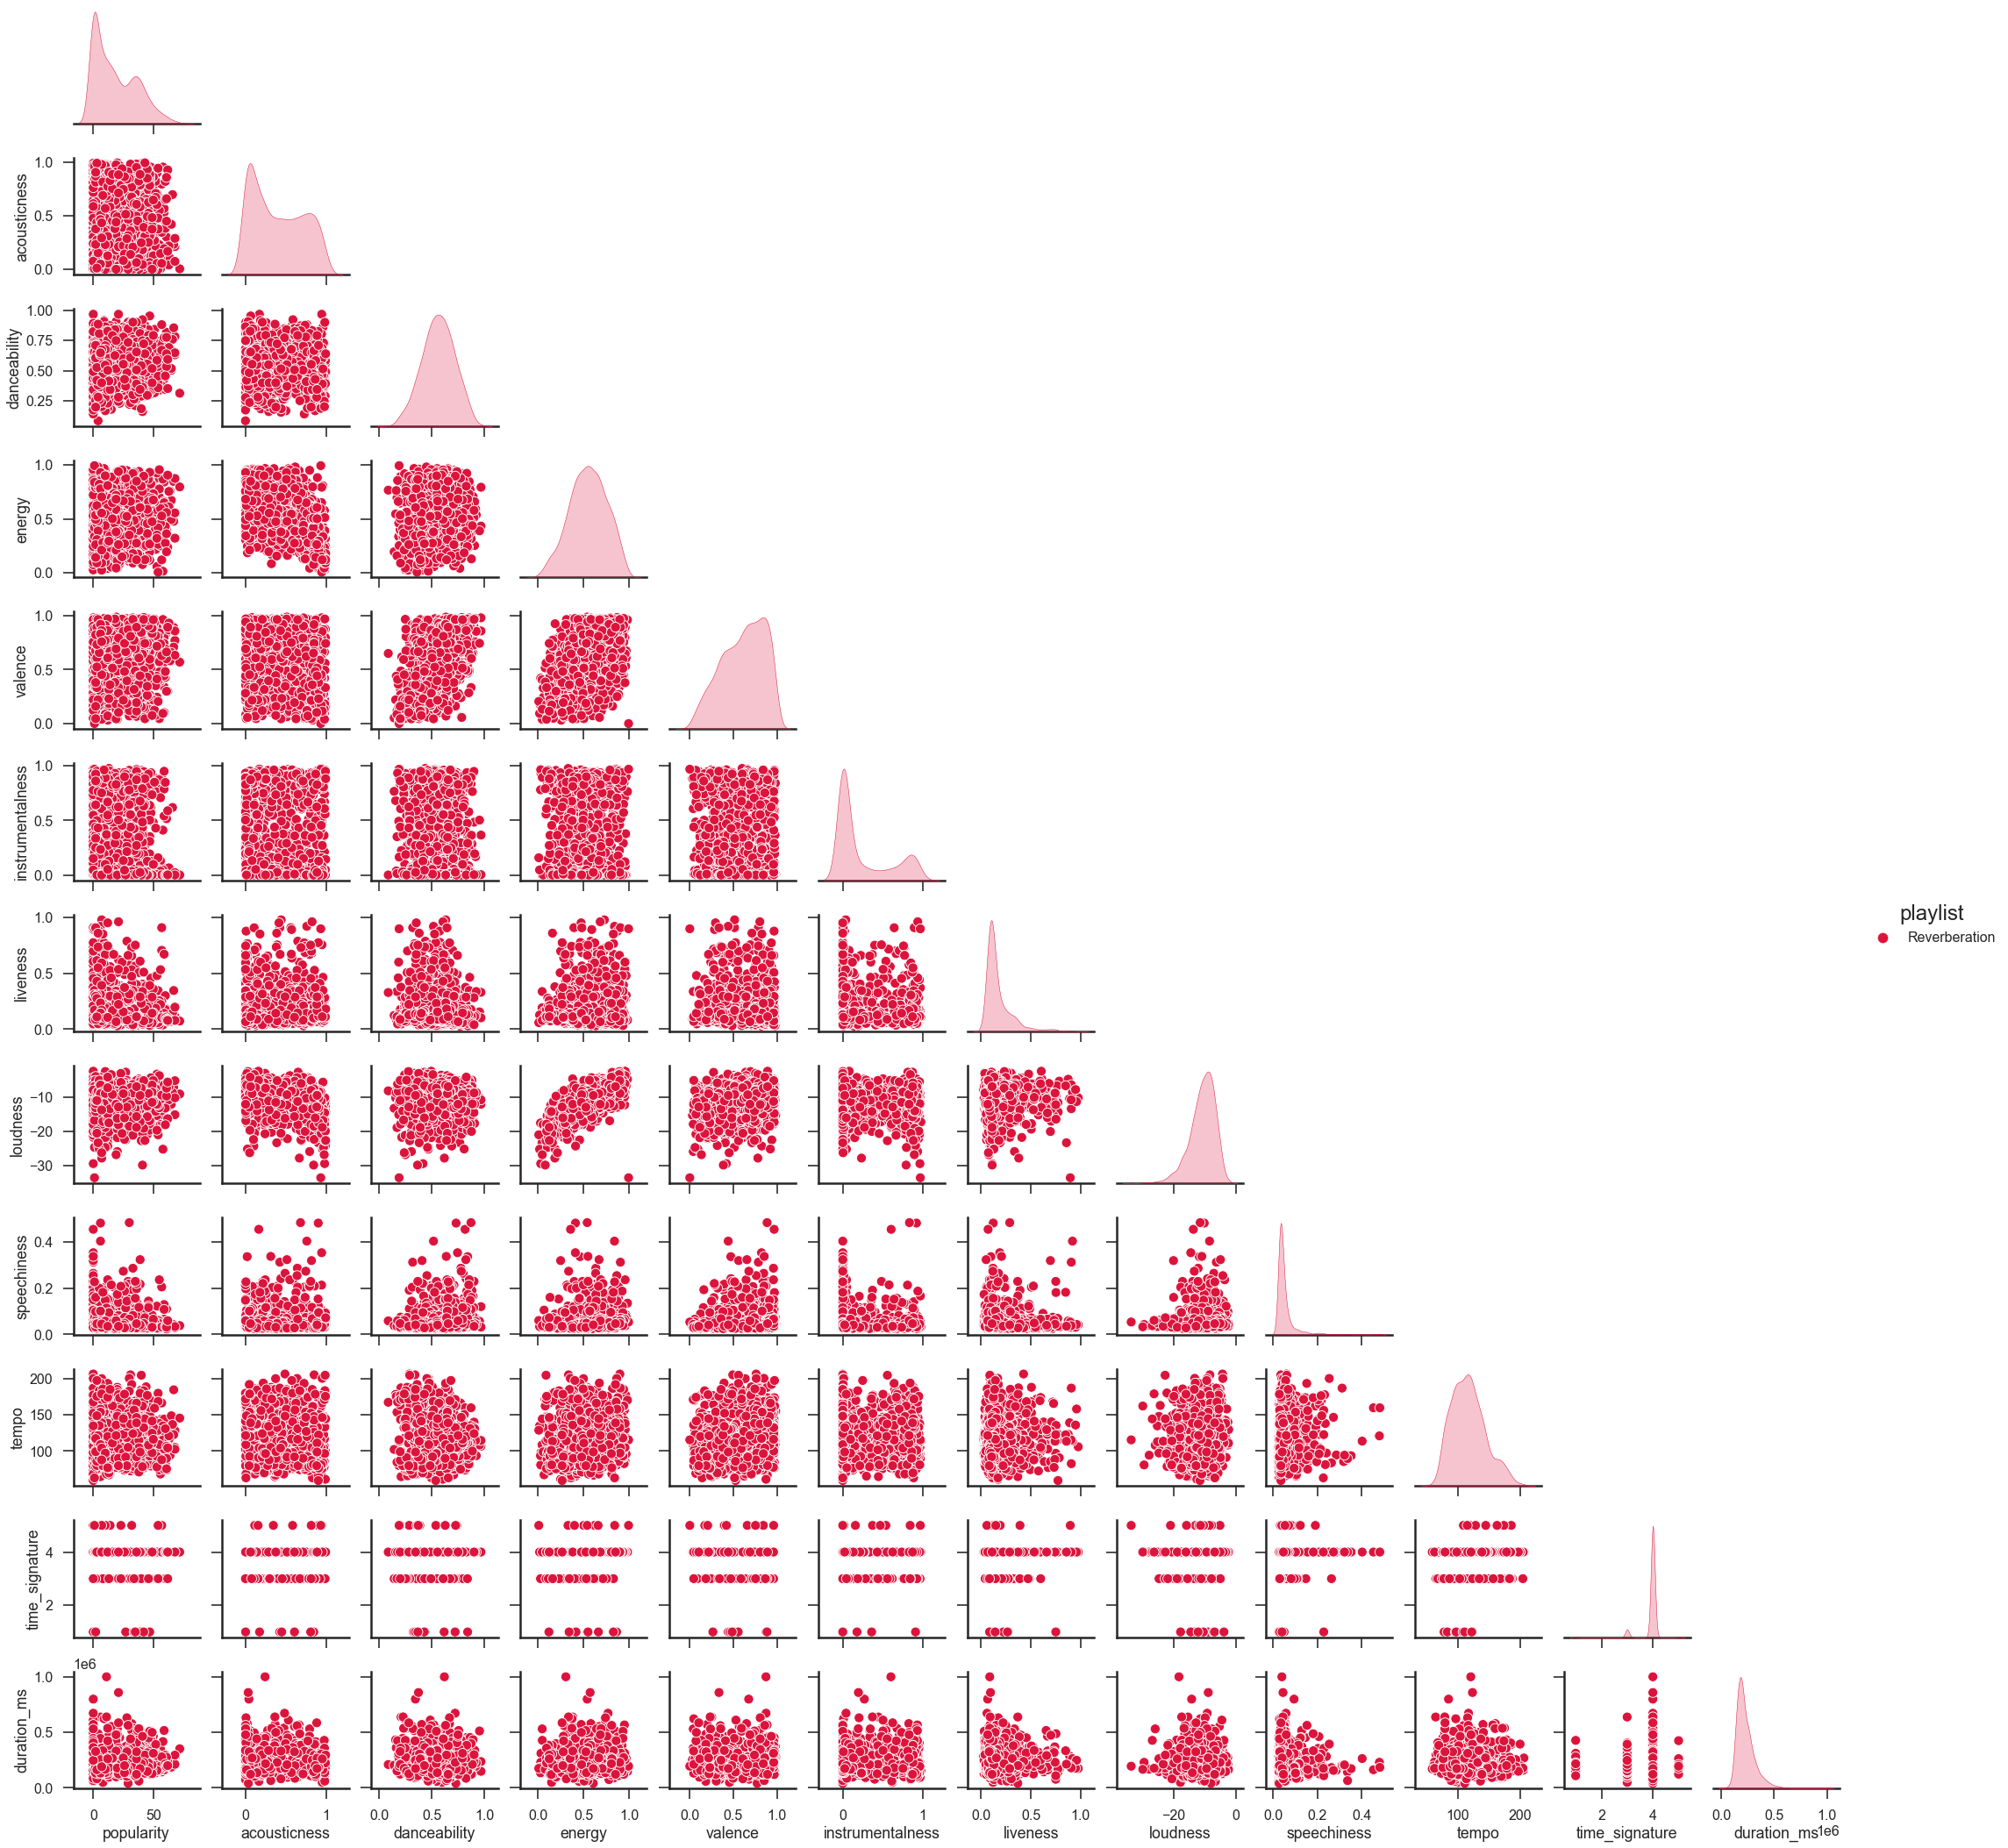

In [80]:
#plt.figure(figsize=(24,8))
sns.pairplot(df[df['playlist']=='Reverberation'][cols],corner=True,hue='playlist',palette=pl_mapping)
#To explore the pairplot in detail, check the saved png file below:
plt.savefig('SxR_pairplot_Reverberation.png', format='png', orientation='landscape')
plt.show()

#### Pairplot for all playlists except Reverberation

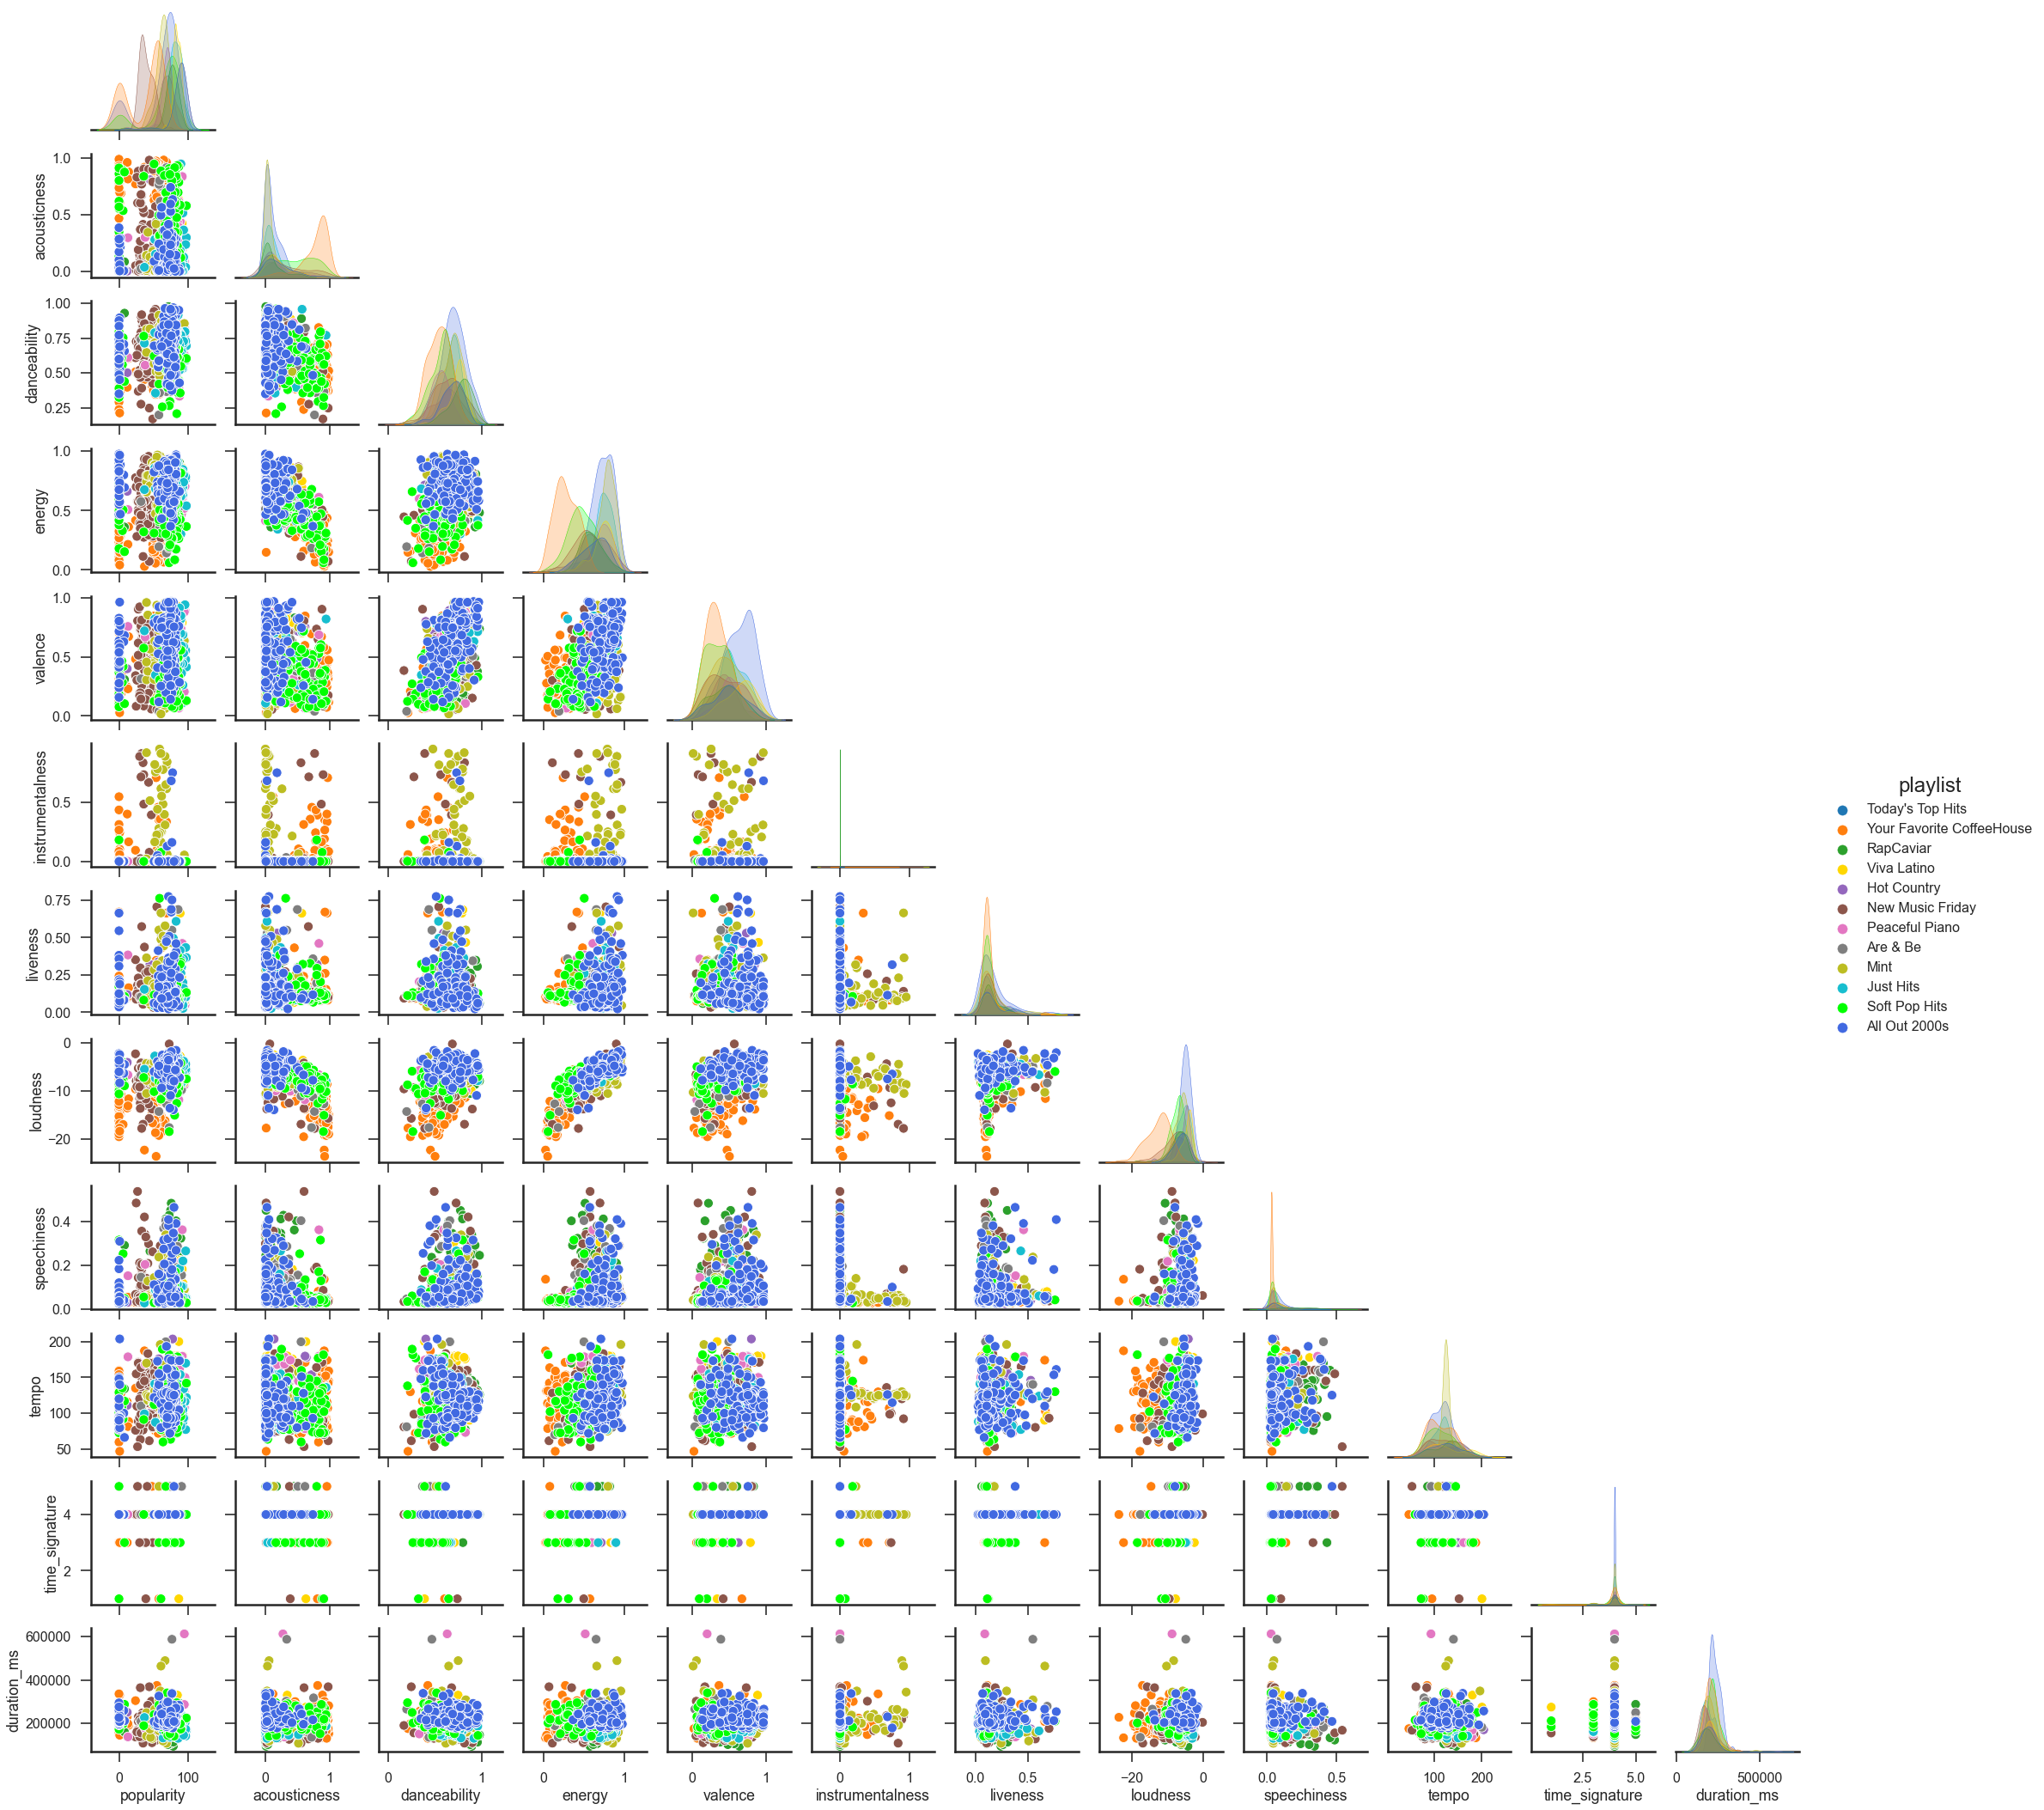

In [81]:
#plt.figure(figsize=(24,8))
sns.pairplot(df[df['playlist']!='Reverberation'][cols],corner=True,hue='playlist',palette=pl_mapping)
#To explore the pairplot in detail, check the saved png file below:
plt.savefig('SxR_pairplot_excl_R.png', format='png', orientation='landscape')
plt.show()

#### Notes:

   * The diagonal represents the univariate distribution. We can already notice differences between playlist with peaks located at different levels. For example, peaks in Popularity, Acousticness or Energy vary across playlists.
   * It seems that Instrumentalness coupled with various other variables would a good indicator to differentiate playlists from one another.

---
### Radar charts to explore audio features across playlists

#### Normalisation

Most audio feature variables range from 1 to 0. For the others, we'll use a scaling technique to transform their range between 0 to 1. Effectively, normalizing the scale of all audio feature variables for further use in a radar chart.

In [82]:
#Selection of variable to normalize
normalization_cols=['speechiness','loudness','tempo','duration_ms']
norm_cols=[col+'_norm' for col in normalization_cols]
#Normalization
df[norm_cols] = MinMaxScaler().fit_transform(df[normalization_cols])
df.columns

Index(['playlist', 'id', 'name', 'album', 'artist', 'genres', 'release_date',
       'popularity', 'acousticness', 'danceability', 'energy', 'valence',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature', 'duration_ms', 'mode', 'type', 'speechiness_norm',
       'loudness_norm', 'tempo_norm', 'duration_ms_norm'],
      dtype='object')

In [83]:
#Snippet to delete unwanted cols during development phase
#to_del = [col for col in df.columns.values if '_norm' in col]
#df.drop(columns=to_del,axis=1,inplace=True)

#### Build radar chart

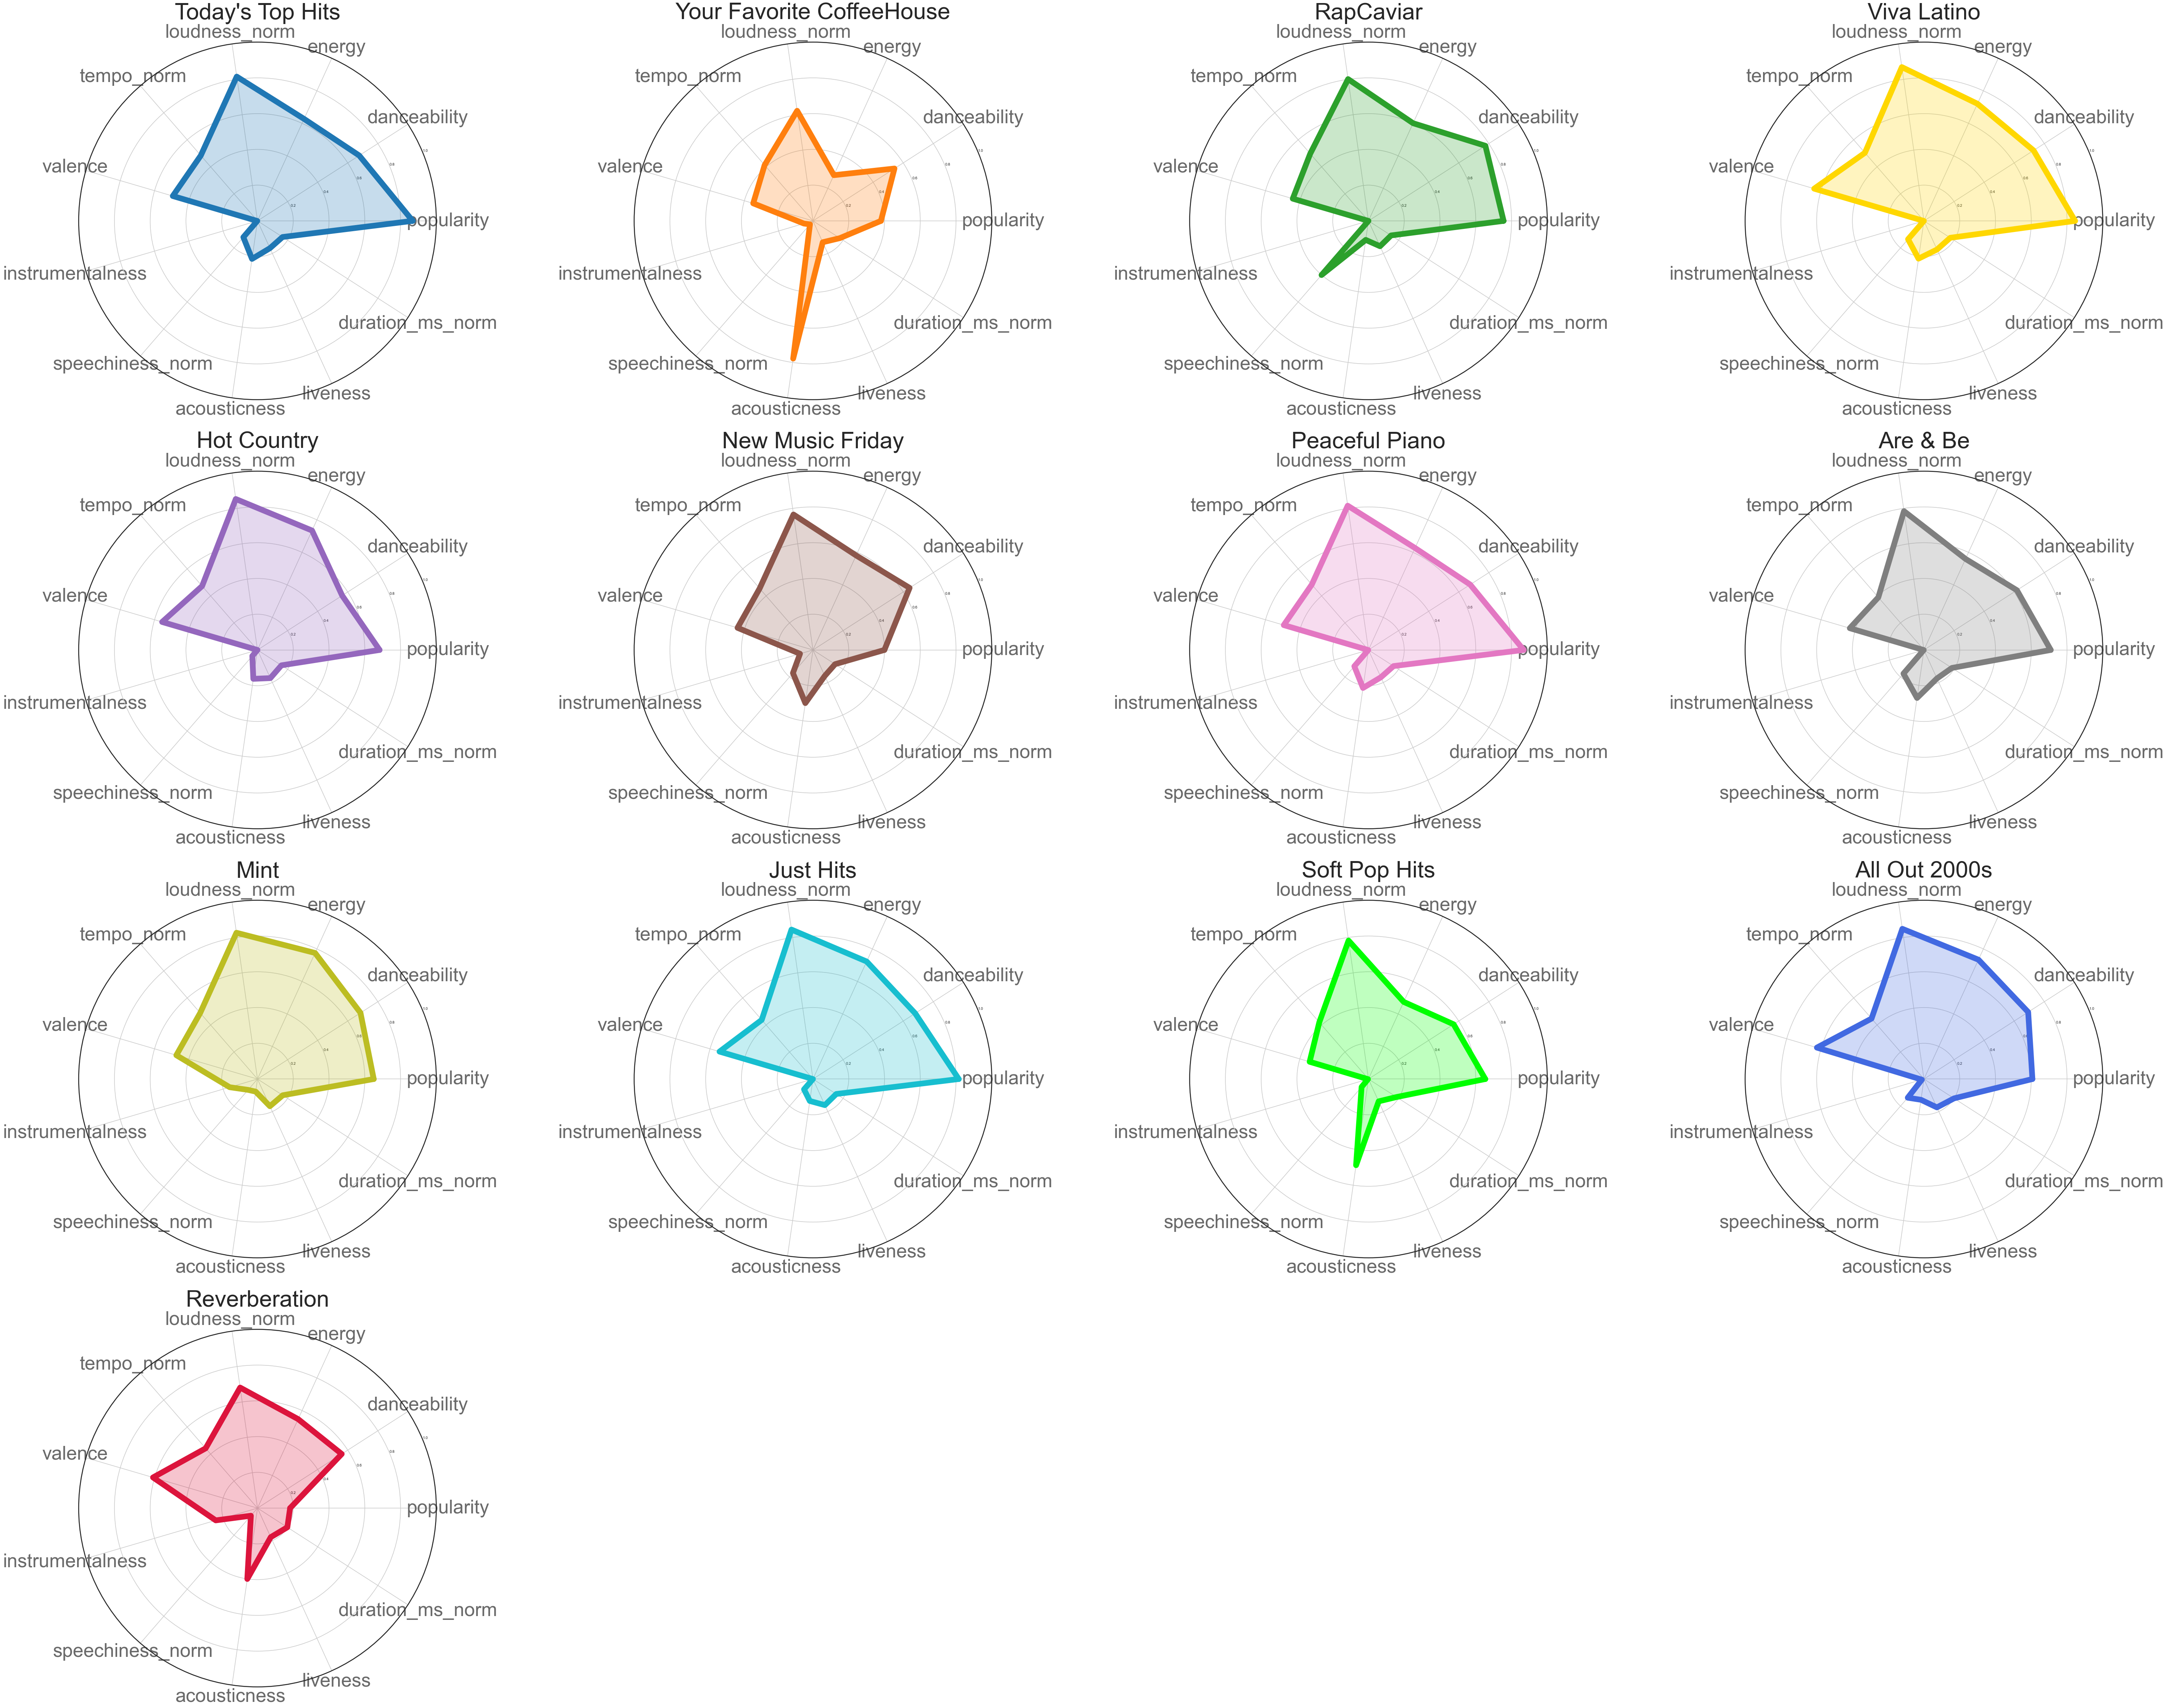

In [86]:
labels = np.array(['popularity', 'danceability','energy', 'loudness_norm', 'tempo_norm' , 'valence'
                   , 'instrumentalness','speechiness_norm' , 'acousticness', 'liveness', 'duration_ms_norm'])
pls = df['playlist'].unique().tolist()

#Create figure
fig=plt.figure(figsize=(100,100))
#Add one subplot with distinct color mapping for each individual playlist
for index_subplot,pl in enumerate(pls,1):

    #Process data for each playlist & create values
    stats = df.loc[df.playlist==pl,labels].mean()
    stats.popularity = stats.popularity/100
    stats = stats.values
    #Create angles for radar
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    #Close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    #Built figure
    ax = fig.add_subplot(5,4,index_subplot, polar=True)
    #Plot
    ax.plot(angles, stats, 'o-', linewidth=15, color=pl_mapping[pl])
    ax.fill(angles, stats, pl_mapping[pl], alpha=0.25)
    #Set axis & legend
    ax.set_thetagrids(angles * 180/np.pi)
    plt.xticks(angles[:-1], labels, color='dimgrey', size=50)
    plt.yticks(size=10)
    ax.set_ylim(0,1)
    ax.set_title(df.loc[df.playlist==pl,'playlist'].iloc[0])
    ax.title.set_size(60)
    ax.grid(True)
#Export graph to explore in details
plt.savefig('SxR_radar_charts.png', format='png', orientation='landscape')

#### Notes:

   * See Appendix for details definition of each audio feature above.

In [113]:
#Resource to set precision: https://www.codegrepper.com/code-examples/python/pandas+format+float+decimal+places
pd.set_option('precision', 3)
df_playlist_agg = df.groupby('playlist')[labels].mean()
df_playlist_agg

popularity  danceability  energy  loudness_norm  \
playlist                                                                     
All Out 2000s                  60.647         0.693   0.734          0.849   
Are & Be                       70.900         0.618   0.560          0.784   
Hot Country                    68.275         0.563   0.734          0.853   
Just Hits                      81.513         0.679   0.723          0.845   
Mint                           65.000         0.685   0.775          0.827   
New Music Friday               39.935         0.642   0.581          0.765   
Peaceful Piano                 86.780         0.676   0.627          0.815   
RapCaviar                      75.560         0.777   0.601          0.801   
Reverberation                  18.237         0.560   0.547          0.681   
Soft Pop Hits                  65.320         0.566   0.474          0.783   
Today's Top Hits               86.780         0.676   0.627          0.815   
Viva Latino                    84.500         0.729   0.720          0.869   
Your Favorite CoffeeHouse      38.000         0.542   0.281          0.622   

                           tempo_norm  valence  instrumentalness  \
playlist                                                           
All Out 2000s                   0.447    0.624         1.237e-02   
Are & Be                        0.390    0.432         1.244e-03   
Hot Country                     0.473    0.556         1.186e-04   
Just Hits                       0.438    0.545         2.147e-04   
Mint                            0.489    0.473         1.622e-01   
New Music Friday                0.455    0.440         7.554e-02   
Peaceful Piano                  0.484    0.494         1.210e-03   
RapCaviar                       0.497    0.441         1.142e-05   
Reverberation                   0.443    0.609         2.432e-01   
Soft Pop Hits                   0.420    0.343         2.675e-03   
Today's Top Hits                0.484    0.494         1.210e-03   
Viva Latino                     0.504    0.640         5.184e-04   
Your Favorite CoffeeHouse       0.413    0.348         5.279e-02   

                           speechiness_norm  acousticness  liveness  \
playlist                                                              
All Out 2000s                         0.138         0.117     0.174   
Are & Be                              0.175         0.271     0.175   
Hot Country                           0.044         0.163     0.173   
Just Hits                             0.077         0.124     0.160   
Mint                                  0.080         0.071     0.167   
New Music Friday                      0.171         0.300     0.159   
Peaceful Piano                        0.121         0.215     0.168   
RapCaviar                             0.401         0.107     0.156   
Reverberation                         0.056         0.400     0.179   
Soft Pop Hits                         0.059         0.487     0.137   
Today's Top Hits                      0.121         0.215     0.168   
Viva Latino                           0.136         0.213     0.176   
Your Favorite CoffeeHouse             0.026         0.778     0.131   

                           duration_ms_norm  
playlist                                     
All Out 2000s                         0.200  
Are & Be                              0.186  
Hot Country                           0.159  
Just Hits                             0.155  
Mint                                  0.168  
New Music Friday                      0.147  
Peaceful Piano                        0.167  
RapCaviar                             0.150  
Reverberation                         0.198  
Soft Pop Hits                         0.186  
Today's Top Hits                      0.167  
Viva Latino                           0.175  
Your Favorite CoffeeHouse             0.179

In [ ]:
violin_metrics=['popularity','valence','energy','duration_ms_norm','instrumentalness']

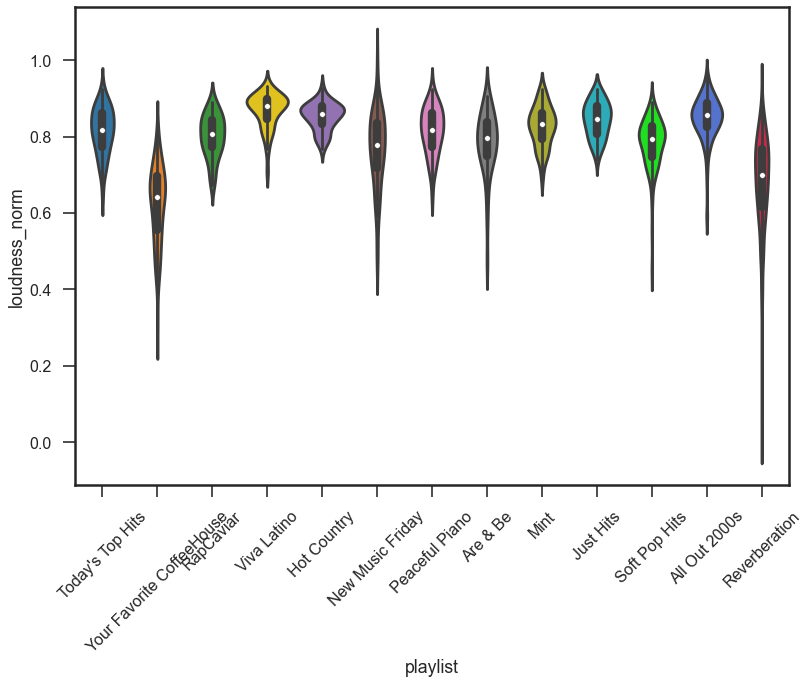

In [116]:
agg_labels=labels[:]
agg_labels = np.append(agg_labels,'playlist')
sns.violinplot(x='playlist',y='loudness_norm',data=df[agg_labels],palette=pl_mapping)
plt.xticks(rotation=45)
plt.show()

Rev has longer tail than other playlist. Potentially due to the diversity of songs and simply, the number of songs.

### Appendix

#### Spotify Audio Features definitions:
in order of appearence:

* <b>Popularity</b>: is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.<br><br>

* <b>Danceability</b>: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.<br><br>

* <b>Energy</b>: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.<br><br>

* <b>Loudness</b>: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing the relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.<br><br>

* <b>Tempo</b>: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration.<br><br>

* <b>Valence</b>: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).<br><br>

* <b>Instrumentalness</b>: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.<br><br>

* <b>Speechiness</b>: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.<br><br>

* <b>Acousticness</b>: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.<br><br>

* <b>Liveness</b>: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.<br><br>